In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Open-Close-Eye/mrl-eye-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/mrl-eye-dataset')

In [25]:
!pip install opencv-python==4.11.0.86
!pip install tensorflow==2.18.0

In [26]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import random

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [27]:
# Define paths
base_path = "/content/mrl-eye-dataset/data"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [28]:
# Ensure sorted and consistent category order
categories = sorted([folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))])
print(f"Sorted Categories: {categories}")

Sorted Categories: ['close eyes', 'open eyes']


## 🖼️ Visualizing Dataset Samples

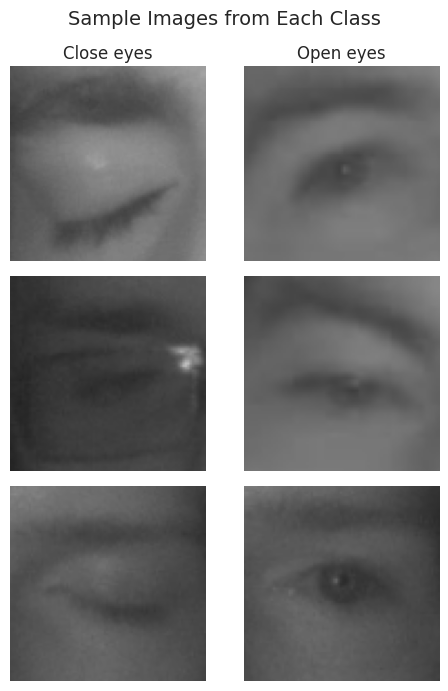

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(5, 7))

for i, category in enumerate(categories):
    image_files = random.sample(os.listdir(os.path.join(train_path, category)), 3)

    for j, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(train_path, category, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[j, i]
        ax.imshow(img)
        ax.axis("off")

        if j == 0:
            ax.set_title(category.capitalize(), fontsize=12, pad=5)

plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

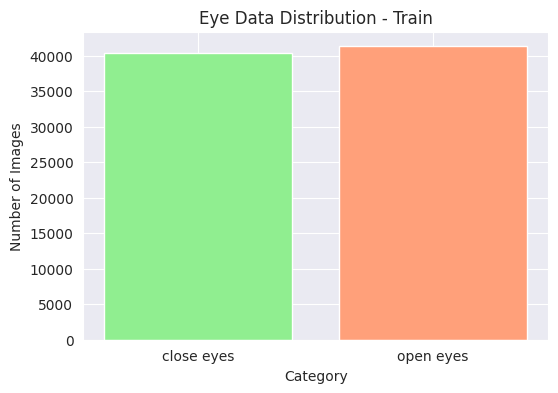

In [30]:
data_distribution = {category: len(os.listdir(os.path.join(train_path, category))) for category in categories}

plt.figure(figsize=(6,4))
plt.bar(data_distribution.keys(), data_distribution.values(), color=["lightgreen", "lightsalmon"])
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Eye Data Distribution - Train")
plt.show()

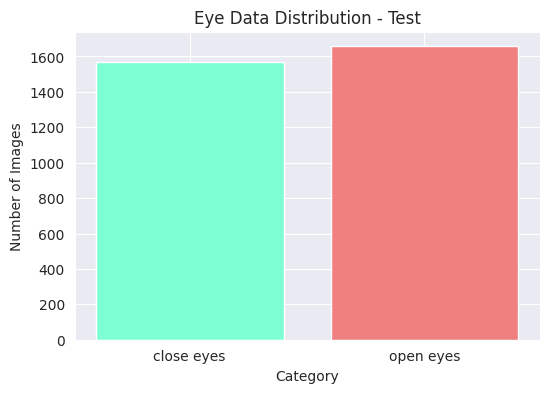

In [31]:
data_distribution = {category: len(os.listdir(os.path.join(test_path, category))) for category in categories}

plt.figure(figsize=(6,4))
plt.bar(data_distribution.keys(), data_distribution.values(), color=["aquamarine", "lightcoral"])
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Eye Data Distribution - Test")
plt.show()

In [32]:
unique_shapes = set()

for category in categories:
  cat_path = os.path.join(train_path, category)
  for file in os.listdir(cat_path):
    img = cv2.imread(os.path.join(cat_path, file))
    if img is not None:
      unique_shapes.add(img.shape[:2])

print(f"Unique image shapes in dataset: {unique_shapes}")

Unique image shapes in dataset: {(267, 267), (84, 84), (277, 277), (61, 61), (116, 116), (126, 126), (181, 181), (272, 272), (176, 176), (153, 153), (208, 208), (218, 218), (57, 57), (273, 273), (122, 122), (117, 117), (94, 94), (149, 149), (214, 214), (209, 209), (241, 241), (58, 58), (90, 90), (246, 246), (150, 150), (127, 127), (182, 182), (242, 242), (297, 297), (274, 274), (91, 91), (123, 123), (68, 68), (279, 279), (63, 63), (238, 238), (183, 183), (160, 160), (215, 215), (64, 64), (220, 220), (59, 59), (124, 124), (101, 101), (156, 156), (216, 216), (248, 248), (65, 65), (97, 97), (253, 253), (92, 92), (157, 157), (212, 212), (189, 189), (184, 184), (194, 194), (88, 88), (249, 249), (98, 98), (286, 286), (70, 70), (125, 125), (180, 180), (190, 190), (245, 245), (222, 222), (217, 217), (227, 227), (121, 121), (66, 66), (282, 282), (131, 131), (186, 186), (158, 158), (213, 213), (223, 223), (62, 62), (278, 278), (72, 72), (250, 250), (260, 260), (99, 99), (154, 154), (164, 164), (

In [43]:
IMG_SIZE = (64, 56)  # (width, height) for OpenCV
PIL_SIZE = (56, 64)  # (height, width) for Keras/Pillow
NUM_SAMPLES = 20

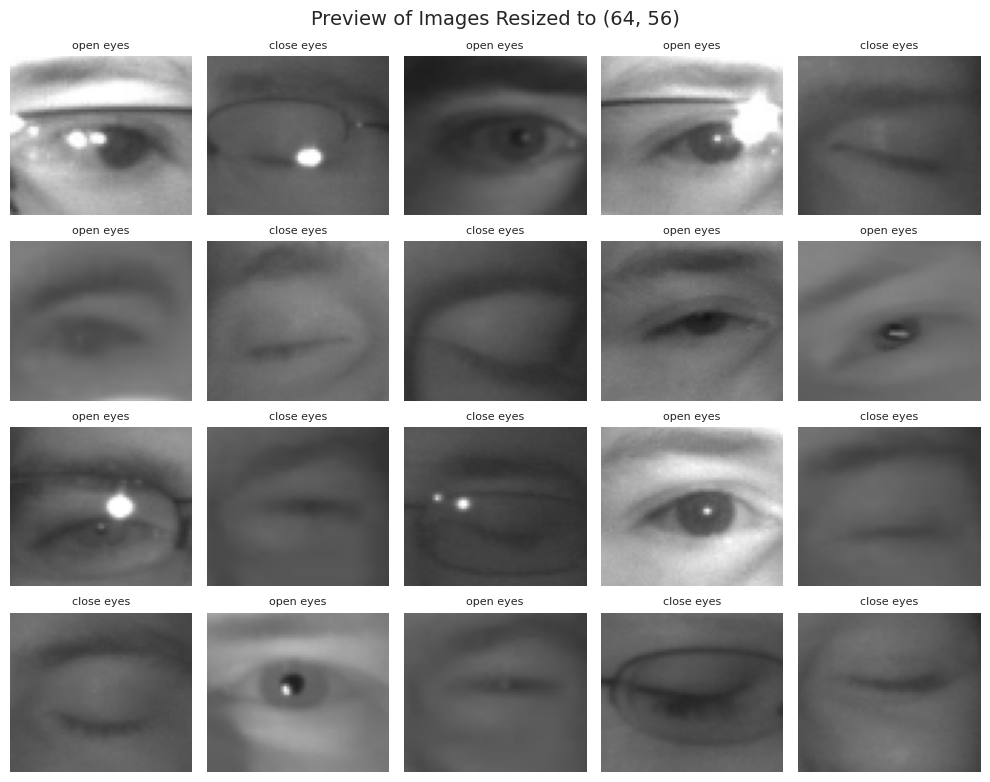

In [47]:
all_images = []
for category in categories:
    cat_path = os.path.join(train_path, category)
    image_files = os.listdir(cat_path)
    sampled_files = random.sample(image_files, min(len(image_files), NUM_SAMPLES // 2))
    all_images.extend([(os.path.join(cat_path, f), category) for f in sampled_files])
random.shuffle(all_images)
cols = 5
rows = (len(all_images) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for idx, (img_path, label) in enumerate(all_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    ax = axes[idx // cols, idx % cols]
    ax.imshow(img)
    ax.set_title(label, fontsize=8)
    ax.axis("off")

for i in range(len(all_images), rows * cols):
    axes[i // cols, i % cols].axis("off")
plt.suptitle(f"Preview of Images Resized to {IMG_SIZE}", fontsize=14)
plt.tight_layout()
plt.show()

# ➕ Augmentation data train

In [55]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

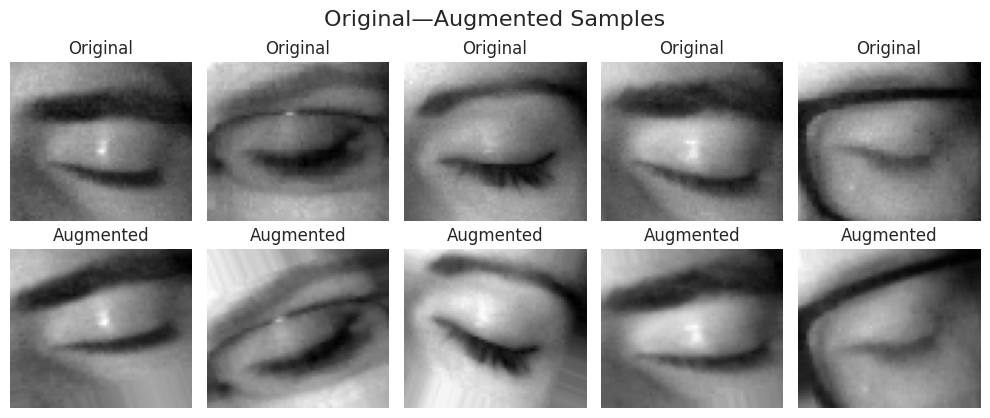

In [56]:
sample_category = categories[0]
sample_path = os.path.join(train_path, sample_category)
sample_files = os.listdir(sample_path)
selected_files = random.sample(sample_files, 5)

plt.figure(figsize=(10, 4))
for i, file_name in enumerate(selected_files):
    img_path = os.path.join(sample_path, file_name)
    img = load_img(img_path, target_size=PIL_SIZE, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    aug_iter = train_datagen.flow(img_array, batch_size=1)
    aug_image = next(aug_iter)[0]
    plt.subplot(2, 5, i+1)
    plt.imshow(img_array[0].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(aug_image.squeeze(), cmap='gray')
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Original—Augmented Samples", fontsize=16, y=1.05)
plt.show()

In [57]:
train_datagen.flow_from_directory(train_path)

Found 81675 images belonging to 2 classes.


# 📦 Create Data Generators

In [59]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=PIL_SIZE,
    color_mode="grayscale",
    classes=categories,
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

Found 81675 images belonging to 2 classes.


In [60]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=PIL_SIZE,
    color_mode="grayscale",
    classes=categories,
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 3223 images belonging to 2 classes.


In [61]:
print("Class indices:", train_generator.class_indices)

Class indices: {'close eyes': 0, 'open eyes': 1}


# 🧠 Define CNN Model

*In summary, batch normalization is a transformative technique that significantly enhances the performance of Convolutional Neural Networks (CNNs). By normalizing activations within each layer, it stabilizes the training process, accelerates convergence, and improves generalization.*

In [63]:
model = Sequential([
    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(56, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flatten and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Prevent overfitting

    # Output Layer for Binary Classification
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 56, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,835,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,929,089 (7.36 MB)

 Trainable params: 1,928,641 (7.36 MB)

 Non-trainable params: 448 (1.75 KB)

# 🏋️‍♂️ Train the Model

In [64]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/15
 273/2553 ━━━━━━━━━━━━━━━━━━━━ 10:13 269ms/step - accuracy: 0.7740 - loss: 0.6256